# Relevance Vector Machine - Regression

In [11]:
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error

from RVR import RVR
from sklearn.svm import SVR
from sklearn import preprocessing

## 1) Linear dataset

In [3]:
# Number of samples.
N = 50

X = np.linspace(0,10,N)
Y = 2*X
T = Y + np.random.randn(N)

X = X.reshape(N,1)

print('X shape:', X.shape)
print('T shape:', T.shape)

X shape: (50, 1)
T shape: (50,)


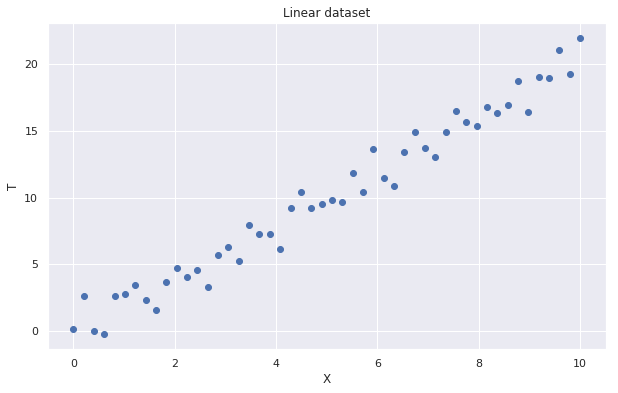

In [4]:
fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.scatter(X, T)
plt.title('Linear dataset')
plt.xlabel('X')
plt.ylabel('T')
plt.show()

In [5]:
rvm = RVR(coef0=0.001)

rvm.fit(X,T)

X_test = np.linspace(0,10,N)
X_test = X_test.reshape(N,1)
y_pred, sigma = rvm.predict(X_test)

print('RMSE:', np.sqrt(mean_squared_error(y_pred, Y)))

relevance_vect = rvm.get_relevance_vectors()
indexes_relev_vect = [i for i,x in enumerate(X) if x in relevance_vect]

print('Number of relevance vectors:', relevance_vect.shape[0])

RMSE: 0.23173384247498516
Number of relevance vectors: 2


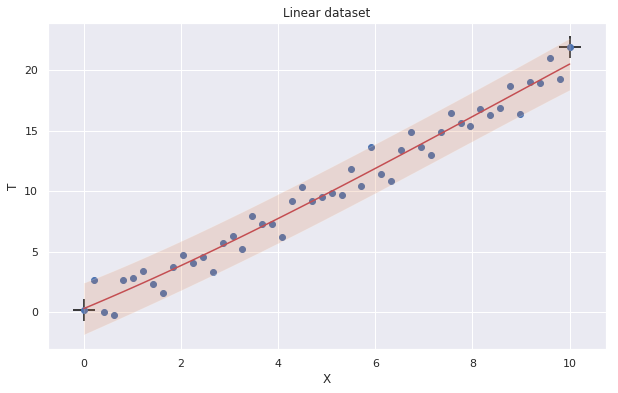

In [6]:
fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.plot(X_test, y_pred,c='r')
plt.scatter(relevance_vect, T[indexes_relev_vect], c='black', marker='+', s=500)
plt.scatter(X, T)
plt.fill_between(X_test.flatten(), y_pred - 2*np.sqrt(np.diag(sigma)), y_pred + 2*np.sqrt(np.diag(sigma)), alpha=0.2)
plt.title('Linear dataset')
plt.xlabel('X')
plt.ylabel('T')
plt.show()

fig.savefig('linear_data.pdf')

## 2) Sinus cardinal dataset

### Without noise

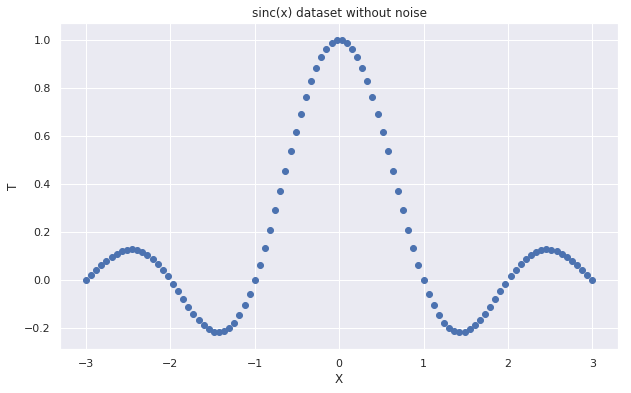

In [119]:
N = 100

X = np.linspace(-3,3,N)
Y = np.sinc(X)
T = Y

X = X.reshape(N,1)

fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.scatter(X, T)
plt.xlabel('X')
plt.ylabel('T')
plt.title('sinc(x) dataset without noise')
plt.show()

RMSE: 0.0031783835466712243


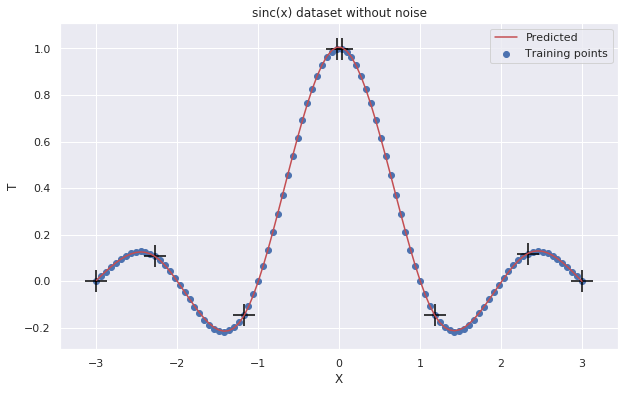

In [120]:
rvm = RVR(kernel='linear_spline', threshold_alpha=1e9, alpha=1e-15, sigma=0.001)

rvm.fit(X,T)

relevance_vect = rvm.get_relevance_vectors()
indexes_relev_vect = [i for i,x in enumerate(X) if x in relevance_vect]

y_pred, sigma = rvm.predict(X)

print('RMSE:', np.sqrt(mean_squared_error(y_pred, Y)))

fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.plot(X, y_pred, c='r', label='Predicted')
plt.scatter(X, T, label='Training points')
plt.scatter(relevance_vect, T[indexes_relev_vect], c='black', marker='+', s=500)
plt.xlabel('X')
plt.ylabel('T')
plt.title('sinc(x) dataset without noise')
plt.legend()
plt.show()

fig.savefig('sinc_rvm_without_noise.pdf')

### SVM comparison

In [121]:
def linear_spline_kernel(X, Y):
        """
            Linear spline kernel.
        """
        phi = np.zeros((X.shape[0], Y.shape[0]))
        
        for i in range(phi.shape[0]):
            for j in range(phi.shape[1]):
                x = X[i]
                y = Y[j]
                phi[i,j] = 1 + x*y + x*y*min(x,y) - \
                ((x+y)*min(x,y)**2)/2 + np.power(min(x,y),3)/3
        
        return phi
    
def linear_spline_kernel_2(data_1, data_2):

        kernel = np.ones((data_1.shape[0], data_2.shape[0]))

        for d in range(data_1.shape[1]):
            column_1 = data_1[:, d].reshape(-1, 1)
            column_2 = data_2[:, d].reshape(-1, 1)
            c_prod = column_1 * column_2.T
            c_sum = column_1 + column_2.T
            c_min = np.minimum(column_1, column_2.T)
            kernel *= 1. + c_prod + c_prod * c_min \
                         - c_sum/2. * c_min ** 2. \
                         + 1./3. * c_min ** 3.
        return kernel
    

In [122]:
# Scale data.
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
#print(X_scaled)

Number support vectors: 26
RMSE: 0.004164342358841906


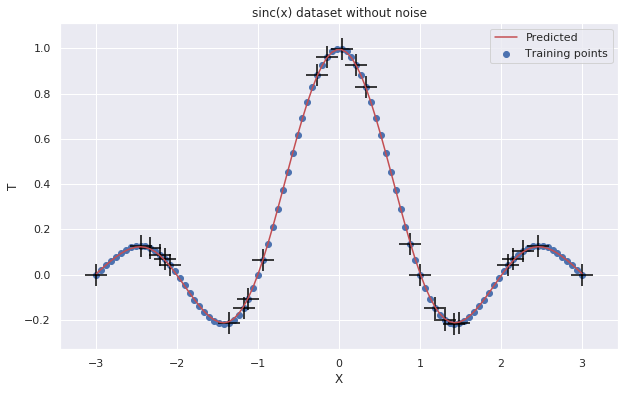

In [124]:
svr = SVR(kernel=linear_spline_kernel, epsilon=5e-3, C=1e3, tol=1e-5)

svr.fit(X_scaled,T)

support_vectors_idx = svr.support_
print('Number support vectors:', len(support_vectors_idx))

y_pred = svr.predict(X_scaled)

print('RMSE:', np.sqrt(mean_squared_error(y_pred, Y)))

fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.plot(X, y_pred, c='r', label='Predicted')
plt.scatter(X, T, label='Training points')
plt.scatter(X[support_vectors_idx], T[support_vectors_idx], c='black', marker='+', s=500)
plt.xlabel('X')
plt.ylabel('T')
plt.title('sinc(x) dataset without noise')
plt.legend()
plt.show()

fig.savefig('sinc_svm_without_noise.pdf')

### With noise

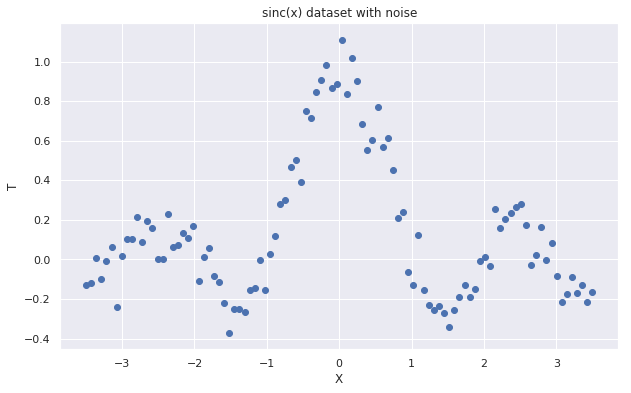

In [57]:
N = 100

X = np.linspace(-3.5,3.5,N)
Y = np.sinc(X)
T = Y + np.random.randn(N) * 0.1

X = X.reshape(N,1)

fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.scatter(X, T)
plt.xlabel('X')
plt.ylabel('T')
plt.title('sinc(x) dataset with noise')
plt.show()

RMSE: 0.04088878108682992


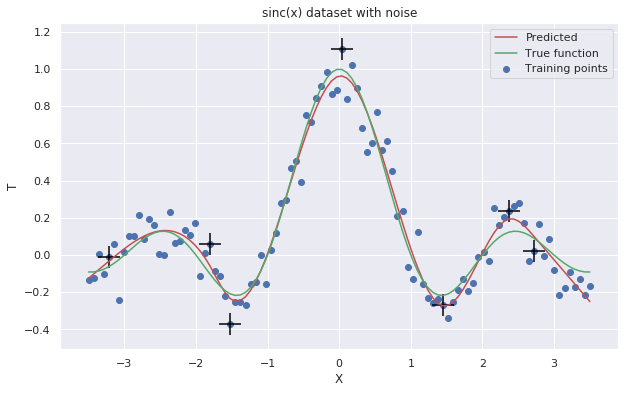

In [58]:
rvm = RVR(kernel='linear_spline', threshold_alpha=1e9, alpha=1e-5, sigma=0.01)

rvm.fit(X,T)

relevance_vect = rvm.get_relevance_vectors()
indexes_relev_vect = [i for i,x in enumerate(X) if x in relevance_vect]

y_pred, sigma = rvm.predict(X)

print('RMSE:', np.sqrt(mean_squared_error(y_pred, Y)))

fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.plot(X, y_pred, c='r', label='Predicted')
plt.scatter(X, T, label='Training points')
plt.scatter(relevance_vect, T[indexes_relev_vect], c='black', marker='+', s=500)
plt.plot(X, Y, c='g', label='True function')
plt.xlabel('X')
plt.ylabel('T')
plt.legend()
plt.title('sinc(x) dataset with noise')
plt.show()

fig.savefig('sinc_rvm_with_noise.pdf')

### SVM comparison

In [60]:
# Scale data.
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
#print(X_scaled)

Number support vectors: 46
RMSE: 0.04894627587865372


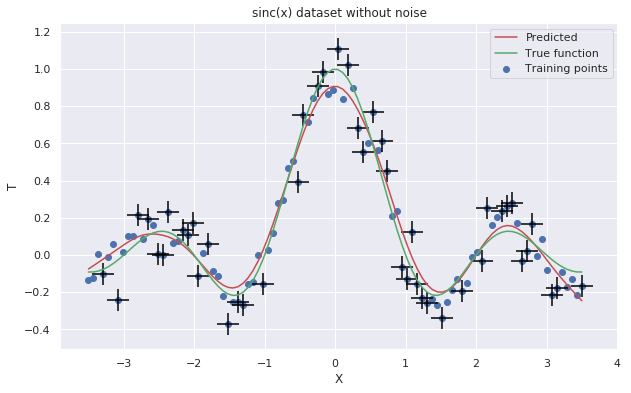

In [118]:
svr = SVR(kernel=linear_spline_kernel, epsilon=8e-2, C=1e3)

svr.fit(X_scaled,T)

support_vectors_idx = svr.support_

print('Number support vectors:', len(support_vectors_idx))

y_pred = svr.predict(X_scaled)

print('RMSE:', np.sqrt(mean_squared_error(y_pred, Y)))

fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.plot(X, y_pred, c='r', label='Predicted')
plt.scatter(X, T, label='Training points')
plt.scatter(X[support_vectors_idx], T[support_vectors_idx], c='black', marker='+', s=500)
plt.plot(X, Y, c='g', label='True function')
plt.xlabel('X')
plt.ylabel('T')
plt.title('sinc(x) dataset without noise')
plt.legend()
plt.show()

fig.savefig('sinc_svm_with_noise.pdf')

## 3) Extension

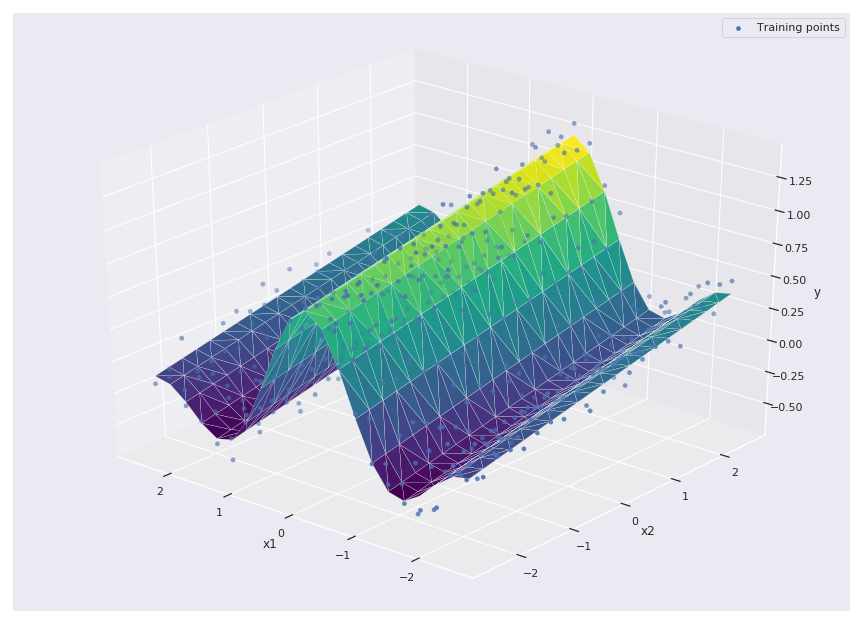

In [107]:
N = 20

X_1 = np.linspace(-2.5,2.5,N+1)
X_2 = np.linspace(-2.5,2.5,N+1)

X = np.zeros(((N+1)**2, 2))

for i, x in enumerate(itertools.product(X_1, X_2)):
    X[i, :] = x

Y = np.sinc(X[:, 0]) + 0.1*X[:, 1]
T = Y + np.random.randn(X.shape[0]) * 0.1

sns.set(style="darkgrid")
fig = plt.figure()
fig.set_size_inches(15, 11)
ax = fig.gca(projection='3d')
ax.invert_xaxis()
ax.plot_trisurf(X[:,0], X[:,1], Y, cmap=plt.cm.viridis, linewidth=0.2)
ax.scatter(X[:,0], X[:,1], T, cmap=plt.cm.viridis, linewidth=0.2, label='Training points')
ax.view_init(30, -50)
ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('y')
plt.legend()
plt.show()

fig.savefig('3d_dataset_generator.pdf')

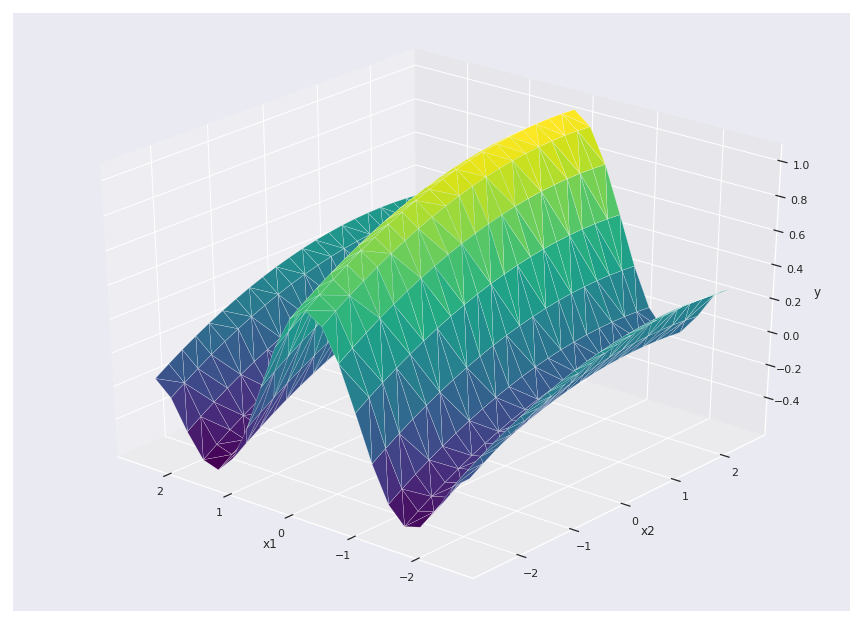

Number of relevance vectors: 7
RMSE :  0.08358982355223372


In [103]:
rvm = RVR(kernel='exponential', threshold_alpha=1e10, alpha=1e-5, sigma=0.101)

rvm.fit(X,T)

relevance_vect = rvm.get_relevance_vectors()
indexes_relev_vect = [i for i,x in enumerate(X) if x in relevance_vect]

y_pred, sigma = rvm.predict(X)

sns.set(style="darkgrid")
fig = plt.figure()
fig.set_size_inches(15, 11)
ax = fig.gca(projection='3d')
ax.invert_xaxis()
ax.plot_trisurf(X[:,0], X[:,1], y_pred, cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(30, -50)
ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('y')
plt.show()

print('Number of relevance vectors:', relevance_vect.shape[0])
print("RMSE : ", np.sqrt(mean_squared_error(y_pred, Y)))

fig.savefig('3d_prediction.pdf')

### SVM comparison

In [104]:
# Scale data.
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
#print(X_scaled)

In [105]:
def exponential_kernel(X, Y):

    phi = np.zeros((X.shape[0], Y.shape[0]))

    for i in range(phi.shape[0]):
        for j in range(phi.shape[1]):
            x_1 = X[i, 0]
            x_2 = X[i, 1]
            y_1 = Y[j, 0]
            y_2 = Y[j, 1]
            phi[i,j] = np.exp(-997e-4*(x_1-y_1)**2 - 2e-4*(x_2-y_2)**2)

    return phi

441
Number support vectors: 338
RMSE: 0.2789335134289013


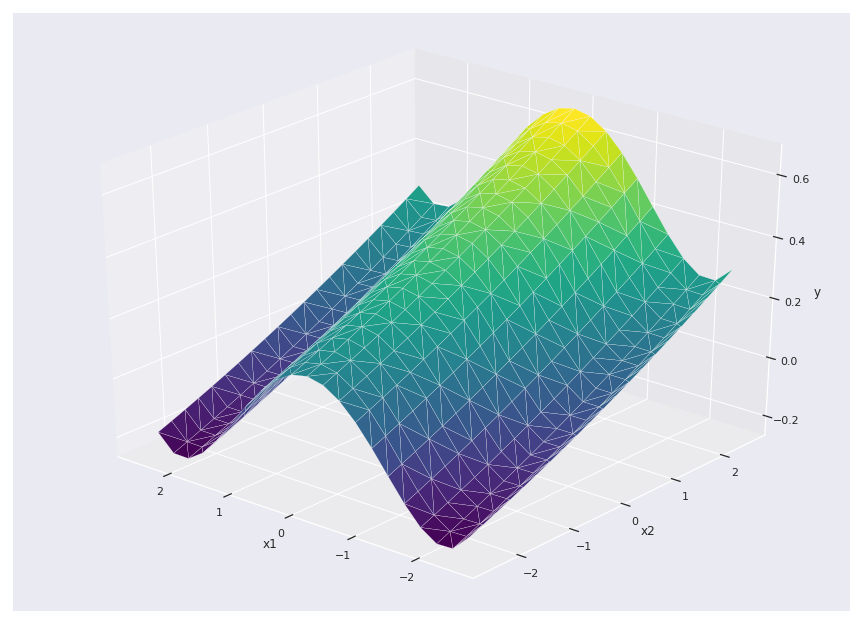

In [106]:
svr = SVR(kernel=exponential_kernel, epsilon=1e-1, C=1e5)

svr.fit(X_scaled,T)

print(X_scaled.shape[0])

support_vectors_idx = svr.support_
print('Number support vectors:', len(support_vectors_idx))

y_pred = svr.predict(X_scaled)
print('RMSE:', np.sqrt(mean_squared_error(y_pred, Y)))

sns.set(style="darkgrid")
fig = plt.figure()
fig.set_size_inches(15, 11)
ax = fig.gca(projection='3d')
ax.invert_xaxis()
ax.plot_trisurf(X[:,0], X[:,1], y_pred, cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(30, -50)
ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('y')
plt.show()